In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
import pycountry
from collections import Counter, defaultdict

In [28]:
df = pd.read_csv('/home/chef/src/DAT6003/data/processed/nlp_sentiment_analysis.csv')
df = df[['sentiment_label', 'sentiment_score', 'parent_issue_id'] + [col for col in df.columns if col not in ['sentiment_label', 'sentiment_score', 'parent_issue_id']]]
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df["created_at"] = pd.to_datetime(df["created_at"], utc=True)

In [29]:
"""
This cell ended up being unused due to graph approach choice.
"""
df1 = df.copy()
B = nx.Graph()  # bipartite graph

# add user nodes (with location as an attribute)
for author, loc in df1[["author", "author_location"]].drop_duplicates().itertuples(index=False):
    B.add_node(f"u:{author}", bipartite="user", author=author, location=loc)

# add issue nodes
for issue_id in df1["parent_issue_id"].dropna().unique():
    B.add_node(f"i:{issue_id}", bipartite="issue", issue_id=issue_id)

# add edges: user participates in issue at time t with sentiment
for row in df1.itertuples(index=False):
    if pd.isna(row.parent_issue_id) or pd.isna(row.author):
        continue
    B.add_edge(
        f"u:{row.author}",
        f"i:{row.parent_issue_id}",
        created_at=row.created_at,
        sentiment_label=row.sentiment_label,
        sentiment_score=float(row.sentiment_score) if pd.notna(row.sentiment_score) else None,
        type=row.type,
        id=row.id,
    )

In [30]:
# collect users per issue (and times) from df directly
issue_to_users = defaultdict(set)
for r in df.dropna(subset=["parent_issue_id","author"]).itertuples(index=False):
    issue_to_users[r.parent_issue_id].add(r.author)

G = nx.Graph()
# add user nodes with location
for author, loc in df[["author","author_location"]].drop_duplicates().itertuples(index=False):
    G.add_node(author, location=loc)

# connect users who co-appear on an issue
for issue, users in issue_to_users.items():
    users = list(users)
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            a, b = users[i], users[j]
            if G.has_edge(a, b):
                G[a][b]["weight"] += 1
            else:
                G.add_edge(a, b, weight=1)

In [31]:
def snapshot_user_graph(df, start, end):
    d = df[(df["created_at"] >= start) & (df["created_at"] < end)]
    issue_to_users = defaultdict(set)
    for r in d.dropna(subset=["parent_issue_id","author"]).itertuples(index=False):
        issue_to_users[r.parent_issue_id].add(r.author)

    Gt = nx.Graph()
    for author, loc in d[["author","author_location"]].drop_duplicates().itertuples(index=False):
        Gt.add_node(author, location=loc)

    for issue, users in issue_to_users.items():
        users = list(users)
        for i in range(len(users)):
            for j in range(i+1, len(users)):
                a, b = users[i], users[j]
                Gt.add_edge(a, b, weight=Gt[a][b]["weight"] + 1 if Gt.has_edge(a,b) else 1)
    return Gt

In [32]:
start = pd.Timestamp("2020-01-01", tz="UTC")
end   = pd.Timestamp("2020-04-01", tz="UTC")
G_q1_2020 = snapshot_user_graph(df, start, end)

In [33]:
pos = nx.spring_layout(G, seed=42, k=0.4, weight="weight")

In [34]:
#posb = nx.spring_layout(B, seed=42, k=0.15)

Text(0.5, 1.0, 'User Network (Min Edge Weight >= 2)')

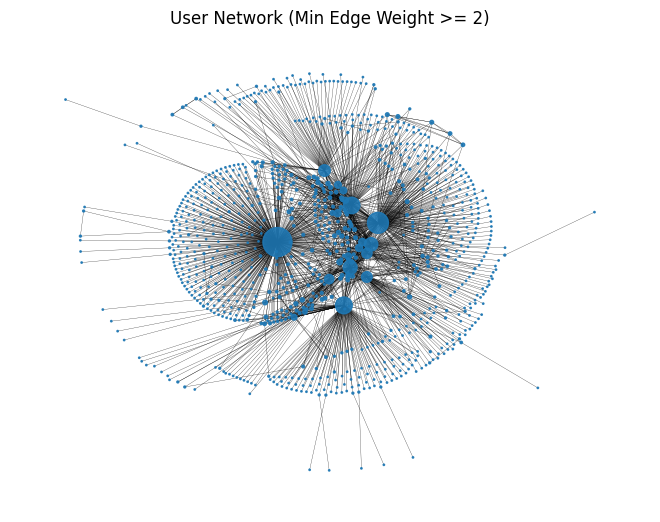

In [35]:
# Keep nodes/edges with weight >= 2, preserving node attributes like location
edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d.get("weight", 1) >= 2]
T = G.edge_subgraph(edges_to_keep).copy()
n = max(T.number_of_nodes(), 1)
pos = nx.kamada_kawai_layout(T, weight=None, scale=15.0) 
sizes = [max(d, 1) for _, d in T.degree()]  # node size proportional to degree
nx.draw(T, pos, node_size=sizes, width=0.2, alpha=0.9, with_labels=False)
plt.title("User Network (Min Edge Weight >= 2)")

Communities found: 23, modularity: 0.3232057964734364


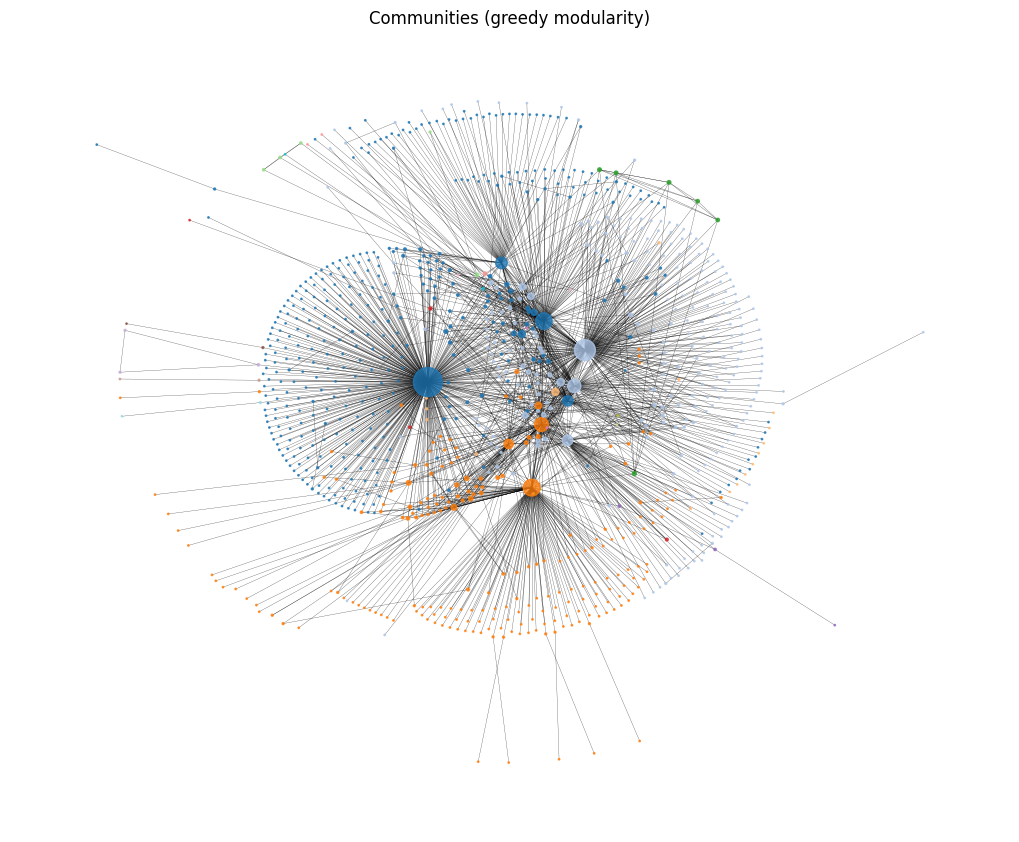

In [36]:
# Community detection (greedy modularity) on T
if T.number_of_nodes() == 0 or T.number_of_edges() == 0:
    communities = []
    modularity = None
else:
    communities = list(nx.algorithms.community.greedy_modularity_communities(T, weight="weight"))
    modularity = nx.algorithms.community.modularity(T, communities, weight="weight")
print(f"Communities found: {len(communities)}, modularity: {modularity}")

# Assign community index to each node
community_index = {}
for idx, comm in enumerate(communities):
    for n in comm:
        community_index[n] = idx
node_comms = [community_index.get(n, -1) for n in T.nodes()]

# Color by community (fallback to grey for unassigned)
palette = plt.cm.tab20.colors
node_colors_comm = [palette[c % len(palette)] if c >= 0 else (0.8, 0.8, 0.8) for c in node_comms]

plt.figure(figsize=(10, 8))
nx.draw(T, pos, node_size=sizes, width=0.2, alpha=0.8, with_labels=False, node_color=node_colors_comm)
plt.title("Communities (greedy modularity)")
plt.show()

Communities found: 18, modularity: 0.32823529136631596


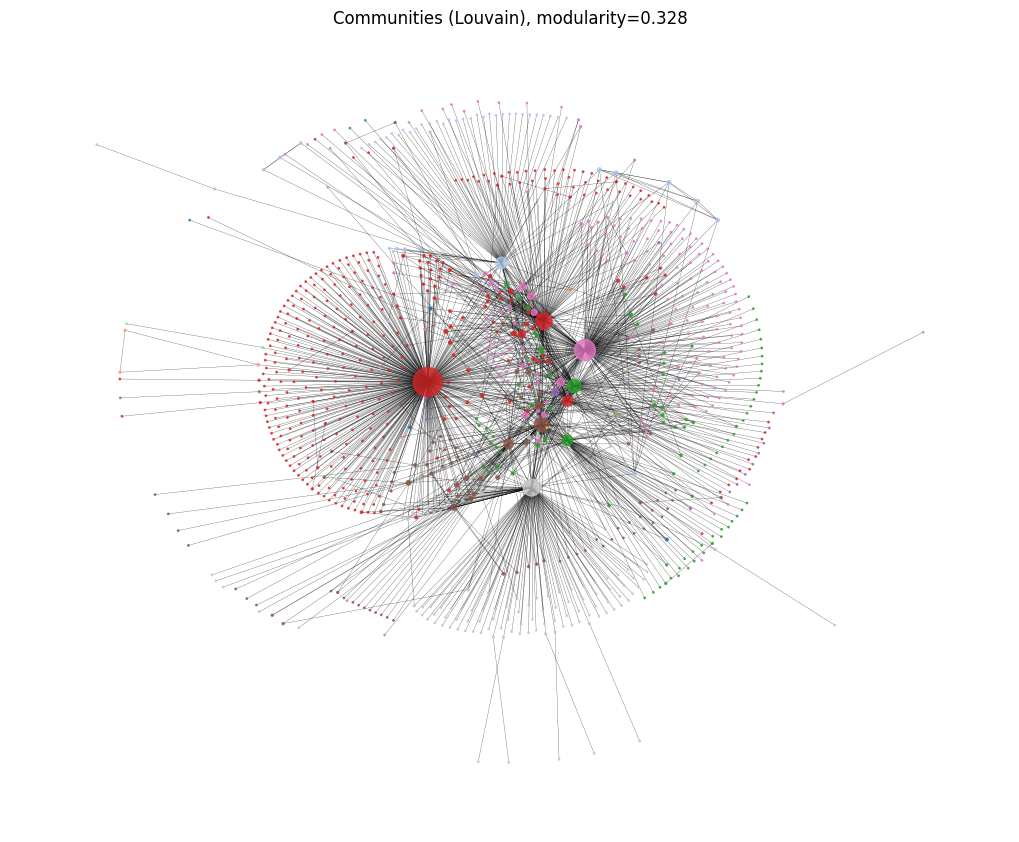

In [37]:
# Community detection using louvain algorithm instead
if T.number_of_nodes() == 0 or T.number_of_edges() == 0:
    communities = []
    modularity = None
    node_comms = [-1 for _ in T.nodes()]
else:
    communities = nx.algorithms.community.louvain_communities(T, weight="weight", resolution=1.0, seed=42)
    modularity = nx.algorithms.community.modularity(T, communities, weight="weight")

    community_index = {}
    for idx, comm in enumerate(communities):
        for n in comm:
            community_index[n] = idx
    node_comms = [community_index.get(n, -1) for n in T.nodes()]

print(f"Communities found: {len(communities)}, modularity: {modularity}")

palette = plt.cm.tab20.colors
node_colors_comm = [palette[c % len(palette)] if c >= 0 else (0.8, 0.8, 0.8) for c in node_comms]

plt.figure(figsize=(10, 8))
nx.draw(T, pos, node_size=sizes, width=0.2, alpha=0.8, with_labels=False, node_color=node_colors_comm)
plt.title(f"Communities (Louvain), modularity={modularity:.3f}" if modularity is not None else "Communities (Louvain)")
plt.show()

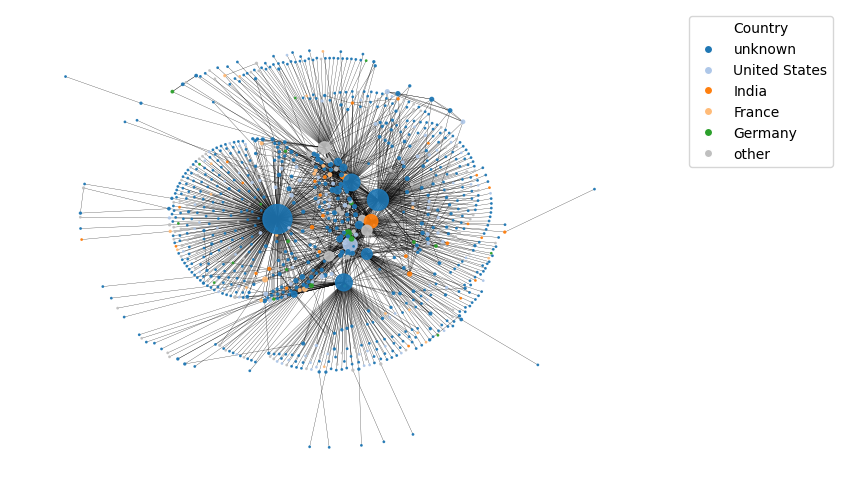

In [38]:
# Plotting with country as colours
def code_to_name(code):
    if not code or (isinstance(code, float) and np.isnan(code)):
        return "unknown"
    code_str = str(code).strip()
    c = pycountry.countries.get(alpha_2=code_str.upper())
    return c.name if c else code_str

# map locations to country names
countries = [code_to_name(T.nodes[n].get("location")) for n in T.nodes()]
counts = Counter(countries)
top5 = [c for c, _ in counts.most_common(5)]
palette = plt.cm.tab20.colors
default_color = (0.75, 0.75, 0.75)  # grey for other countries
color_lookup = {c: palette[i % len(palette)] for i, c in enumerate(top5)}
node_colors = [color_lookup.get(c, default_color) for c in countries]

nx.draw(T, pos, node_size=sizes, width=0.2, alpha=0.9, with_labels=False, node_color=node_colors)
handles = [plt.Line2D([0], [0], marker='o', color='w', label=c, markerfacecolor=color_lookup[c], markersize=6) for c in top5]
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='other', markerfacecolor=default_color, markersize=6))
plt.legend(handles=handles, title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')

Nodes: 959, Edges: 1615
Average degree: 3.368
Max degree: 438
Average clustering (weighted): 0.0091
Density: 0.003516


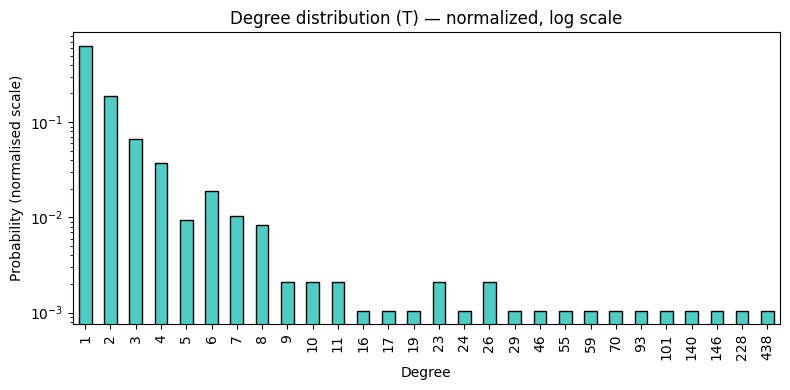

In [39]:
# Network metrics on T - degree distribution, clustering, density
deg_series = pd.Series(dict(T.degree()))
degree_counts = deg_series.value_counts().sort_index()
degree_freq = degree_counts / degree_counts.sum()  # normalized frequencies
avg_clustering = nx.average_clustering(T, weight="weight")
density = nx.density(T)
print(f"Nodes: {T.number_of_nodes()}, Edges: {T.number_of_edges()}")
print(f"Average degree: {deg_series.mean():.3f}")
print(f"Max degree: {deg_series.max()}")
print(f"Average clustering (weighted): {avg_clustering:.4f}")
print(f"Density: {density:.6f}")

plt.figure(figsize=(8,4))
degree_freq.plot(kind="bar", color="#4ECDC4", edgecolor="black", logy=True)
plt.xlabel("Degree")
plt.ylabel("Probability (normalised scale)")
plt.title("Degree distribution (T) — normalized, log scale")
plt.tight_layout()
plt.show()

Top 5 degree centrality: [('LysandreJik', 0.45720250521920663), ('patrickvonplaten', 0.23799582463465552), ('thomwolf', 0.15240083507306887), ('sgugger', 0.14613778705636743), ('julien-c', 0.10542797494780792)]
Top 5 closeness centrality: [('LysandreJik', 0.638000406654238), ('patrickvonplaten', 0.5494415787961483), ('sgugger', 0.5205397833810179), ('thomwolf', 0.5111014246713621), ('julien-c', 0.506647381754836)]
Top 5 betweenness centrality: [('LysandreJik', 0.5264626795722979), ('patrickvonplaten', 0.2332829647176671), ('thomwolf', 0.19825566387130086), ('sgugger', 0.12361436806077832), ('patil-suraj', 0.08795706959929875)]
Top 5 eigenvector centrality: [('LysandreJik', 0.567427030673422), ('sgugger', 0.445828243543198), ('patrickvonplaten', 0.4021592287104461), ('stas00', 0.2727528395573127), ('julien-c', 0.2372679791010999)]


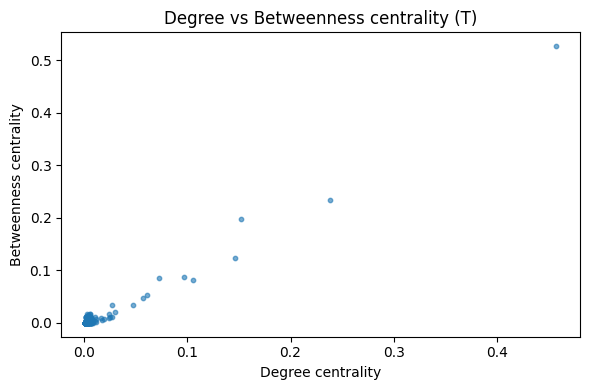

In [40]:
# Centrality measures on T - degree, closeness, betweenness, eigenvector
deg_cent = nx.degree_centrality(T)
close_cent = nx.closeness_centrality(T)
betw_cent = nx.betweenness_centrality(T, weight="weight", normalized=True)
try:
    eig_cent = nx.eigenvector_centrality(T, weight="weight", max_iter=500)
except nx.PowerIterationFailedConvergence:
    eig_cent = {n: np.nan for n in T.nodes()}

def topk(d, k=5):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]
print("Top 5 degree centrality:", topk(deg_cent))
print("Top 5 closeness centrality:", topk(close_cent))
print("Top 5 betweenness centrality:", topk(betw_cent))
print("Top 5 eigenvector centrality:", topk(eig_cent))

plt.figure(figsize=(6,4))
plt.scatter([deg_cent[n] for n in T.nodes()], [betw_cent[n] for n in T.nodes()], s=10, alpha=0.6)
plt.xlabel("Degree centrality")
plt.ylabel("Betweenness centrality")
plt.title("Degree vs Betweenness centrality (T)")
plt.tight_layout()
plt.show()

In [41]:
# Reusable helper to report average centralities (uses existing centrality dicts or computes from a graph)

def _mean_no_nan(d):
    if d is None or len(d) == 0:
        return np.nan
    vals = [v for v in d.values() if pd.notna(v)]
    return float(np.mean(vals)) if vals else np.nan


def centrality_averages(deg_c=None, close_c=None, betw_c=None, eig_c=None, graph=None):
    """Return a dict of mean centralities; if dicts are missing and a graph is provided, compute them."""
    if graph is not None and (deg_c is None or close_c is None or betw_c is None or eig_c is None):
        deg_c = nx.degree_centrality(graph)
        close_c = nx.closeness_centrality(graph)
        betw_c = nx.betweenness_centrality(graph, weight="weight", normalized=True)
        try:
            eig_c = nx.eigenvector_centrality(graph, weight="weight", max_iter=500)
        except nx.PowerIterationFailedConvergence:
            eig_c = {n: np.nan for n in graph.nodes()}
    return {
        "degree_centrality_mean": _mean_no_nan(deg_c),
        "closeness_centrality_mean": _mean_no_nan(close_c),
        "betweenness_centrality_mean": _mean_no_nan(betw_c),
        "eigenvector_centrality_mean": _mean_no_nan(eig_c),
    }

avg_cent = centrality_averages(deg_cent, close_cent, betw_cent, eig_cent, graph=T)
print(pd.Series(avg_cent))

degree_centrality_mean         0.003516
closeness_centrality_mean      0.359229
betweenness_centrality_mean    0.002399
eigenvector_centrality_mean    0.006392
dtype: float64


In [42]:
# Split graph into pre-Q4 2022 vs Q4 2022+ and compare centralities
cutoff = pd.Timestamp("2022-10-01", tz="UTC")
df_pre = df[df["created_at"] < cutoff]
df_post = df[df["created_at"] >= cutoff]

def build_user_graph(df_slice, min_weight=2):
    """
    For constructing a graph given a slice of the dataframe
    """
    issue_to_users = defaultdict(set)
    for r in df_slice.dropna(subset=["parent_issue_id", "author"]).itertuples(index=False):
        issue_to_users[r.parent_issue_id].add(r.author)

    G_slice = nx.Graph()
    for author, loc in df_slice[["author", "author_location"]].drop_duplicates().itertuples(index=False):
        G_slice.add_node(author, location=loc)

    for issue, users in issue_to_users.items():
        users = list(users)
        for i in range(len(users)):
            for j in range(i + 1, len(users)):
                a, b = users[i], users[j]
                if G_slice.has_edge(a, b):
                    G_slice[a][b]["weight"] += 1
                else:
                    G_slice.add_edge(a, b, weight=1)

    edges_to_keep = [(u, v) for u, v, d in G_slice.edges(data=True) if d.get("weight", 1) >= min_weight]
    T_slice = G_slice.edge_subgraph(edges_to_keep).copy()
    return G_slice, T_slice


def compute_centralities(T_graph):
    """"
    For computing the centralities of a given graph (expect T, not Bipartite)
    """
    if T_graph.number_of_nodes() == 0:
        return {}, {}, {}, {}
    deg_cent = nx.degree_centrality(T_graph)
    close_cent = nx.closeness_centrality(T_graph)
    betw_cent = nx.betweenness_centrality(T_graph, weight="weight", normalized=True)
    try:
        eig_cent = nx.eigenvector_centrality(T_graph, weight="weight", max_iter=500)
    except nx.PowerIterationFailedConvergence:
        eig_cent = {n: np.nan for n in T_graph.nodes()}
    return deg_cent, close_cent, betw_cent, eig_cent


def topk(d, k=5):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]


G_pre, T_pre = build_user_graph(df_pre, min_weight=2)
G_post, T_post = build_user_graph(df_post, min_weight=2)

deg_pre, close_pre, betw_pre, eig_pre = compute_centralities(T_pre)
deg_post, close_post, betw_post, eig_post = compute_centralities(T_post)


def report(label, T_graph, deg_c, close_c, betw_c, eig_c):
    """
    For more gracefully handling calls to view descriptive data.
    """
    deg_series = pd.Series(dict(T_graph.degree()))
    avg_deg = deg_series.mean() if not deg_series.empty else 0.0
    print(f"{label}: nodes={T_graph.number_of_nodes()}, edges={T_graph.number_of_edges()}, avg_degree={avg_deg:.3f}")
    if not deg_c:
        print("  (empty graph after min_weight filter)")
        return
    print("  top degree:", topk(deg_c))
    print("  top closeness:", topk(close_c))
    print("  top betweenness:", topk(betw_c))
    print("  top eigenvector:", topk(eig_c))


report("Pre-Q4 2022 (<2022-10-01)", T_pre, deg_pre, close_pre, betw_pre, eig_pre)
report("Q4 2022 onwards (>=2022-10-01)", T_post, deg_post, close_post, betw_post, eig_post)

Pre-Q4 2022 (<2022-10-01): nodes=911, edges=1510, avg_degree=3.315
  top degree: [('LysandreJik', 0.45164835164835165), ('patrickvonplaten', 0.23076923076923078), ('thomwolf', 0.15934065934065933), ('sgugger', 0.14395604395604394), ('julien-c', 0.10659340659340659)]
  top closeness: [('LysandreJik', 0.6346873270614277), ('patrickvonplaten', 0.5466018492040797), ('sgugger', 0.518950226244344), ('thomwolf', 0.5135130294618071), ('julien-c', 0.5052779980615032)]
  top betweenness: [('LysandreJik', 0.5232532681839354), ('patrickvonplaten', 0.22191255270068758), ('thomwolf', 0.21082235628442528), ('sgugger', 0.12784106691976604), ('patil-suraj', 0.0914884619554976)]
  top eigenvector: [('LysandreJik', 0.569460466704468), ('sgugger', 0.44566392907186464), ('patrickvonplaten', 0.4024191022115757), ('stas00', 0.27928104614059435), ('julien-c', 0.23878402764779103)]
Q4 2022 onwards (>=2022-10-01): nodes=23, edges=27, avg_degree=2.348
  top degree: [('ArthurZucker', 0.4090909090909091), ('Lysand

In [44]:
pre_avg_cent = centrality_averages(deg_pre, close_pre, betw_pre, eig_pre, graph=T_pre)
post_avg_cent = centrality_averages(deg_post, close_post, betw_post, eig_post, graph=T_post)
print(pd.Series(pre_avg_cent))
print(pd.Series(post_avg_cent))

degree_centrality_mean         0.003643
closeness_centrality_mean      0.357479
betweenness_centrality_mean    0.002522
eigenvector_centrality_mean    0.006541
dtype: float64
degree_centrality_mean         0.106719
closeness_centrality_mean      0.329981
betweenness_centrality_mean    0.064747
eigenvector_centrality_mean    0.160532
dtype: float64


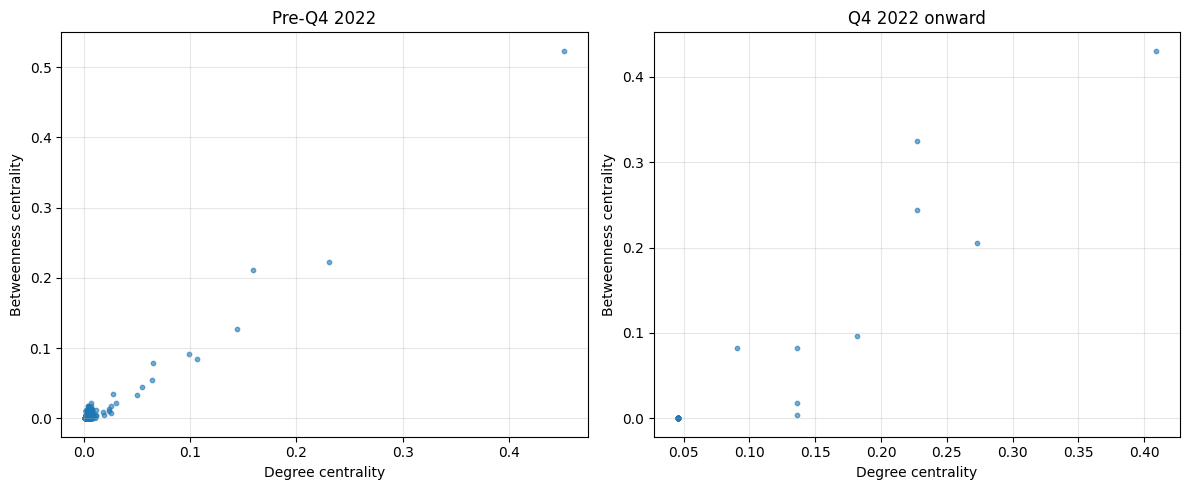

In [61]:
# Comparing degree and betweenness for both periods
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plots = [
    ("Pre-Q4 2022", T_pre, deg_pre, betw_pre),
    ("Q4 2022 onward", T_post, deg_post, betw_post),
]
for ax, (label, T_graph, deg_c, betw_c) in zip(axes, plots):
    if not deg_c:
        ax.text(0.5, 0.5, "Empty after filter", ha="center", va="center")
        ax.set_axis_off()
        continue
    ax.scatter(list(deg_c.values()), list(betw_c.values()), s=10, alpha=0.6)
    ax.set_xlabel("Degree centrality")
    ax.set_ylabel("Betweenness centrality")
    ax.set_title(label)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

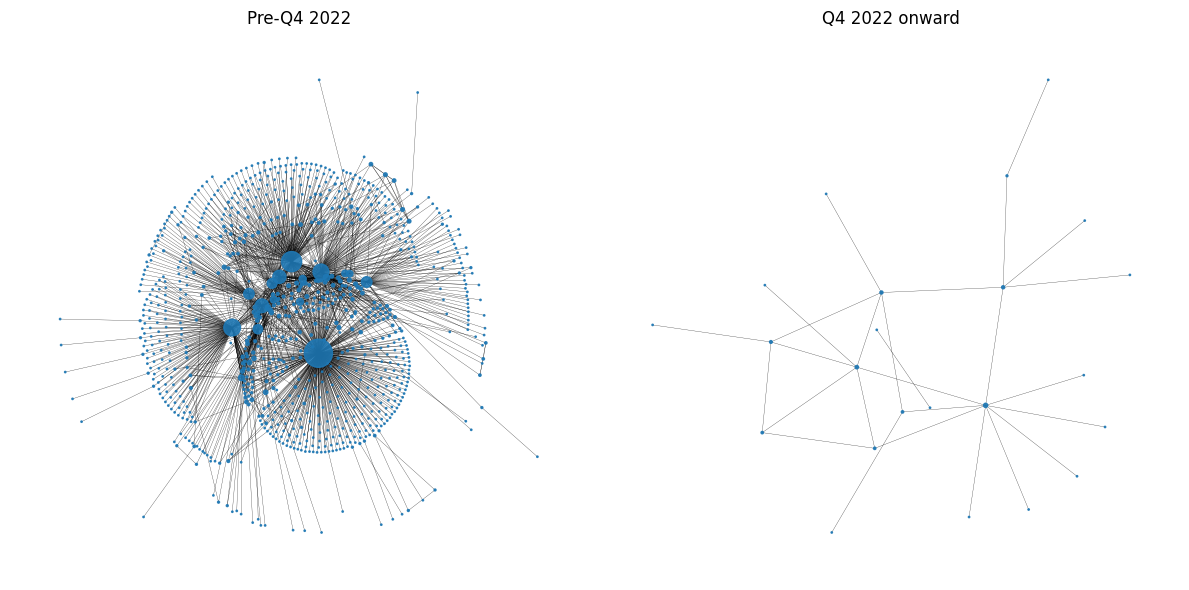

In [62]:
# Visualise the two period networks
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plots = [
    ("Pre-Q4 2022", T_pre),
    ("Q4 2022 onward", T_post),
]
for ax, (label, T_graph) in zip(axes, plots):
    if T_graph.number_of_nodes() == 0:
        ax.text(0.5, 0.5, "Empty after min_weight filter", ha="center", va="center")
        ax.set_axis_off()
        continue
    pos_local = nx.kamada_kawai_layout(T_graph, weight=None, scale=15.0)
    sizes_local = [max(d, 1) for _, d in T_graph.degree()]
    nx.draw(
        T_graph,
        pos_local,
        node_size=sizes_local,
        width=0.2,
        alpha=0.9,
        with_labels=False,
        ax=ax,
    )
    ax.set_title(label)
plt.tight_layout()
plt.show()

In [67]:
# Split into <2020-06-01 vs 2020-06-01 through 2022
cutoff_mid = pd.Timestamp("2020-06-01", tz="UTC")
cutoff_upper = pd.Timestamp("2023-01-01", tz="UTC")

df_window = df[df["created_at"] < cutoff_upper]
df_pre_mid = df_window[df_window["created_at"] < cutoff_mid]
df_mid_to_2022 = df_window[df_window["created_at"] >= cutoff_mid]

G_pre_mid, T_pre_mid = build_user_graph(df_pre_mid, min_weight=2)
G_mid_2022, T_mid_2022 = build_user_graph(df_mid_to_2022, min_weight=2)

deg_pre_mid, close_pre_mid, betw_pre_mid, eig_pre_mid = compute_centralities(T_pre_mid)
deg_mid_2022, close_mid_2022, betw_mid_2022, eig_mid_2022 = compute_centralities(T_mid_2022)

report("Up to June 2020", T_pre_mid, deg_pre_mid, close_pre_mid, betw_pre_mid, eig_pre_mid)
report("Between June 2020 and 2022 (excluding 2023)", T_mid_2022, deg_mid_2022, close_mid_2022, betw_mid_2022, eig_mid_2022)

Up to June 2020: nodes=261, edges=377, avg_degree=2.889
  top degree: [('thomwolf', 0.4653846153846154), ('LysandreJik', 0.3769230769230769), ('julien-c', 0.17692307692307693), ('BramVanroy', 0.1423076923076923), ('patrickvonplaten', 0.09615384615384616)]
  top closeness: [('thomwolf', 0.634915714008913), ('LysandreJik', 0.6015788507435286), ('julien-c', 0.5317753975981824), ('BramVanroy', 0.5207883026064845), ('patrickvonplaten', 0.5001221001221001)]
  top betweenness: [('thomwolf', 0.6040878608027413), ('LysandreJik', 0.44490082330740055), ('julien-c', 0.12020318853330092), ('BramVanroy', 0.11663628694649715), ('patrickvonplaten', 0.10235952227064082)]
  top eigenvector: [('LysandreJik', 0.5581914981973217), ('julien-c', 0.44148927969330065), ('thomwolf', 0.4264066258259554), ('BramVanroy', 0.3980054743143881), ('stefan-it', 0.18870141721630038)]
Between June 2020 and 2022 (excluding 2023): nodes=641, edges=1069, avg_degree=3.335
  top degree: [('LysandreJik', 0.4390625), ('patrickvo

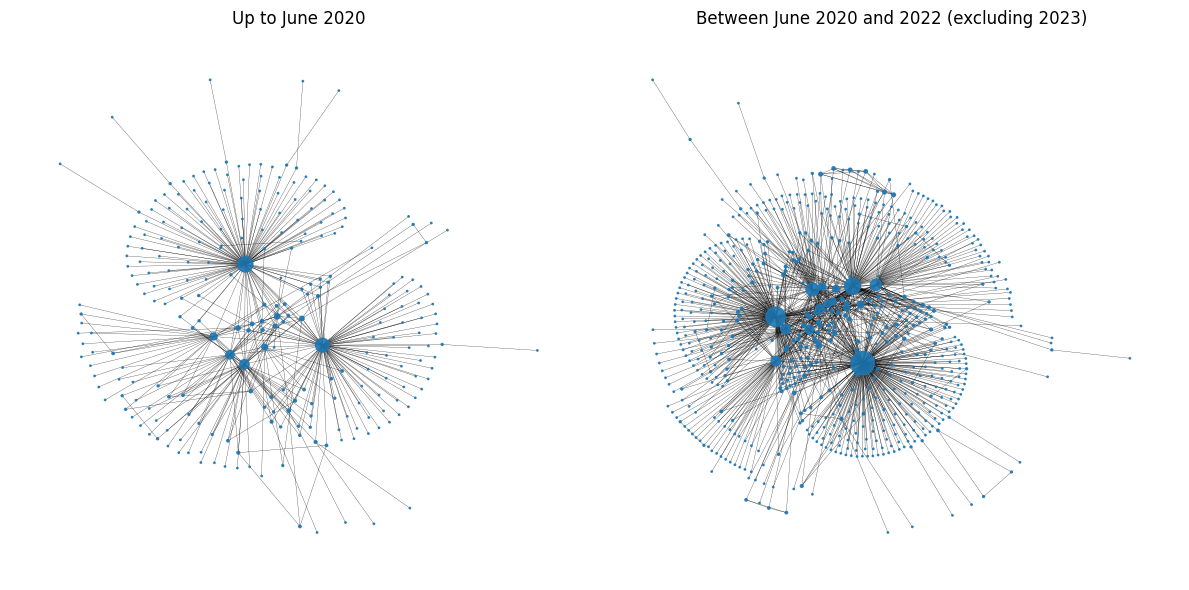

In [66]:
# Visualise
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plots = [
    ("Up to June 2020", T_pre_mid),
    ("Between June 2020 and 2022 (excluding 2023)", T_mid_2022),
]
for ax, (label, T_graph) in zip(axes, plots):
    if T_graph.number_of_nodes() == 0:
        ax.text(0.5, 0.5, "Empty after min_weight filter", ha="center", va="center")
        ax.set_axis_off()
        continue
    pos_local = nx.kamada_kawai_layout(T_graph, weight=None, scale=15.0)
    sizes_local = [max(d, 1) for _, d in T_graph.degree()]
    nx.draw(
        T_graph,
        pos_local,
        node_size=sizes_local,
        width=0.2,
        alpha=0.9,
        with_labels=False,
        ax=ax,
    )
    ax.set_title(label)
plt.tight_layout()
plt.show()

There were 9 communities detected in graph Up to June 2020
There were 15 communities detected in graph Between June 2020 and 2022 (excluding 2023)


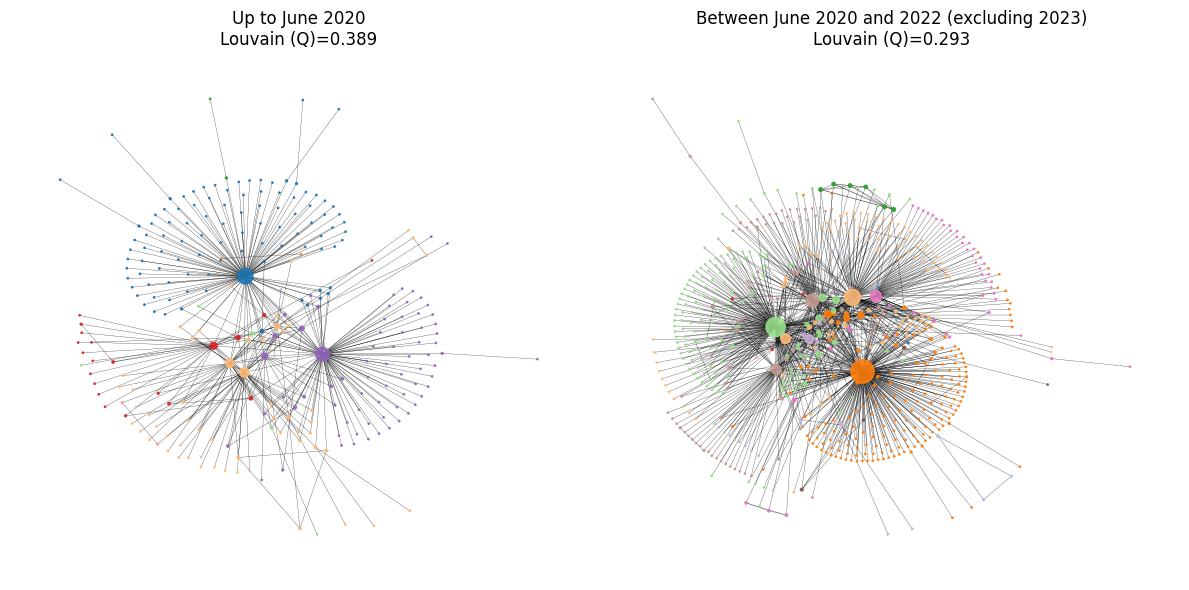

In [71]:
# Louvain communities for the above network graphs
palette = plt.cm.tab20.colors

def louvain_colors(T_graph):
    if T_graph.number_of_nodes() == 0 or T_graph.number_of_edges() == 0:
        return [], None, [], []
    communities = nx.algorithms.community.louvain_communities(T_graph, weight="weight", resolution=1.0, seed=42)
    modularity = nx.algorithms.community.modularity(T_graph, communities, weight="weight")
    community_index = {}
    for idx, comm in enumerate(communities):
        for n in comm:
            community_index[n] = idx
    node_comms = [community_index.get(n, -1) for n in T_graph.nodes()]
    node_colors = [palette[c % len(palette)] if c >= 0 else (0.8, 0.8, 0.8) for c in node_comms]
    return communities, modularity, node_comms, node_colors

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plots = [
    ("Up to June 2020", T_pre_mid),
    ("Between June 2020 and 2022 (excluding 2023)", T_mid_2022),
]
for ax, (label, T_graph) in zip(axes, plots):
    communities, modularity, node_comms, node_colors = louvain_colors(T_graph)
    if not communities:
        ax.text(0.5, 0.5, "Empty after min_weight filter", ha="center", va="center")
        ax.set_axis_off()
        continue
    pos_local = nx.kamada_kawai_layout(T_graph, weight=None, scale=15.0)
    sizes_local = [max(d, 1) for _, d in T_graph.degree()]
    nx.draw(
        T_graph,
        pos_local,
        node_size=sizes_local,
        width=0.2,
        alpha=0.9,
        with_labels=False,
        node_color=node_colors,
        ax=ax,
    )
    title = f"{label}\nLouvain (Q)={modularity:.3f}" if modularity is not None else label
    ax.set_title(title)
    print(f'There were {len(communities)} communities detected in graph {label}')
plt.tight_layout()
plt.show()

In [78]:
# Network metrics
def metrics_summary(T_graph):
    if T_graph.number_of_nodes() == 0:
        return {
            "nodes": 0,
            "edges": 0,
            "avg_degree": 0.0,
            "max_degree": 0,
            "avg_clustering": 0.0,
            "density": 0.0,
            "degree_freq": pd.Series(dtype=float),
        }
    deg_series = pd.Series(dict(T_graph.degree()))
    degree_counts = deg_series.value_counts().sort_index()
    degree_freq = degree_counts / degree_counts.sum()
    avg_clustering = nx.average_clustering(T_graph, weight="weight")
    density = nx.density(T_graph)
    return {
        "nodes": T_graph.number_of_nodes(),
        "edges": T_graph.number_of_edges(),
        "avg_degree": deg_series.mean(),
        "max_degree": deg_series.max(),
        "avg_clustering": avg_clustering,
        "density": density,
        "degree_freq": degree_freq,
    }

stats_pre = metrics_summary(T_pre_mid)
stats_mid = metrics_summary(T_mid_2022)

for label, stats in [
    ("Up to June 2020", stats_pre),
    ("Between June 2020 and 2022 (excluding 2023)", stats_mid),
]:
    print(
        f"{label}: nodes={stats['nodes']}, edges={stats['edges']}, "
        f"avg_degree={stats['avg_degree']:.3f}, max_degree={stats['max_degree']}, "
        f"avg_clustering={stats['avg_clustering']:.4f}, density={stats['density']:.6f}"
    )


Up to June 2020: nodes=261, edges=377, avg_degree=2.889, max_degree=121, avg_clustering=0.0235, density=0.011111
Between June 2020 and 2022 (excluding 2023): nodes=641, edges=1069, avg_degree=3.335, max_degree=281, avg_clustering=0.0096, density=0.005212


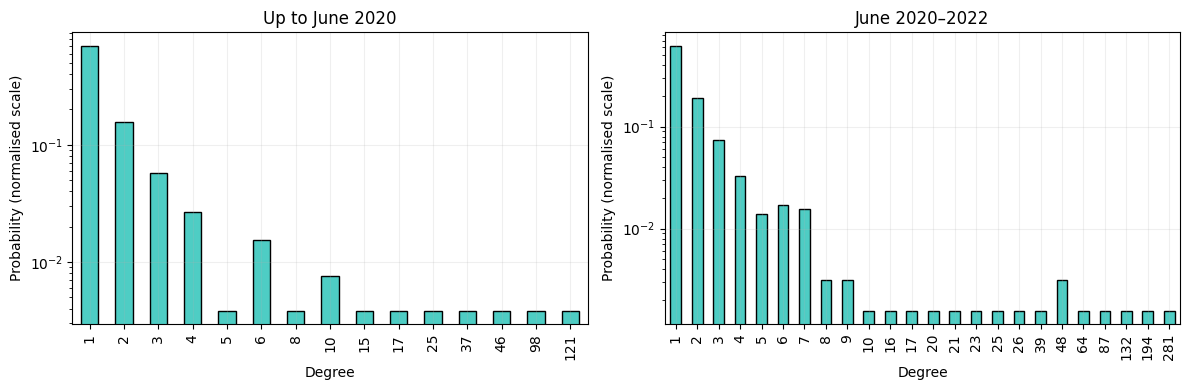

In [79]:
# Plot degree distributions side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plots = [
    ("Up to June 2020", stats_pre["degree_freq"]),
    ("June 2020–2022", stats_mid["degree_freq"]),
]
for ax, (label, deg_freq) in zip(axes, plots):
    if deg_freq.empty:
        ax.text(0.5, 0.5, "Empty after min_weight filter", ha="center", va="center")
        ax.set_axis_off()
        continue
    deg_freq.plot(kind="bar", color="#4ECDC4", edgecolor="black", logy=True, ax=ax)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Probability (normalised scale)")
    ax.set_title(label)
    ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [74]:
# Compare high-centrality regions vs high-activity regions on T (all time)

def canonical_country(val):
    """Map raw author_location to a readable country name/code."""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return "unknown"
    val_str = str(val).strip()
    c = pycountry.countries.get(alpha_2=val_str.upper())
    return c.name if c else val_str

# Centralities per node
betw = nx.betweenness_centrality(T, weight="weight", normalized=True)
degc = nx.degree_centrality(T)
node_country = {n: canonical_country(T.nodes[n].get("location")) for n in T.nodes()}
cent_df = pd.DataFrame({
    "node": list(T.nodes()),
    "country": [node_country[n] for n in T.nodes()],
    "betweenness": [betw.get(n, 0.0) for n in T.nodes()],
    "degree_centrality": [degc.get(n, 0.0) for n in T.nodes()],
})

# Aggregate centralities by country
country_cent = cent_df.groupby("country").agg(
    node_count=("node", "count"),
    betweenness_mean=("betweenness", "mean"),
    betweenness_max=("betweenness", "max"),
    degree_mean=("degree_centrality", "mean"),
    degree_max=("degree_centrality", "max"),
)

# Activity volume per country (all records)
df_activity = df.assign(country_norm=df["author_location"].apply(canonical_country))
activity = df_activity.groupby("country_norm").size().rename("activity_count")

# Combine activity and centrality, fill missing with 0
combined = country_cent.join(activity, how="outer").fillna(0)
combined_sorted = combined.sort_values("activity_count", ascending=False)
top_activity = combined_sorted.head(10)
top_central = combined.sort_values("betweenness_max", ascending=False).head(10)

print("Top 10 countries by activity (comments/issues):")
print(top_activity[["activity_count", "node_count", "betweenness_mean", "betweenness_max"]])

print("\nTop 10 countries by betweenness_max (bridging role):")
print(top_central[["activity_count", "node_count", "betweenness_mean", "betweenness_max"]])


Top 10 countries by activity (comments/issues):
                    activity_count  node_count  betweenness_mean  \
unknown                      27147       636.0          0.002605   
United States                 3149       100.0          0.001810   
Canada                        1751        13.0          0.004563   
India                         1576        30.0          0.004350   
Belgium                       1254         3.0          0.039887   
Germany                        886        21.0          0.001495   
France                         687        27.0          0.001437   
China                          475        19.0          0.000199   
Ireland                        320         5.0          0.004269   
Korea, Republic of             317        11.0          0.000266   

                    betweenness_max  
unknown                    0.526463  
United States              0.081586  
Canada                     0.048133  
India                      0.087957  
Belgium      

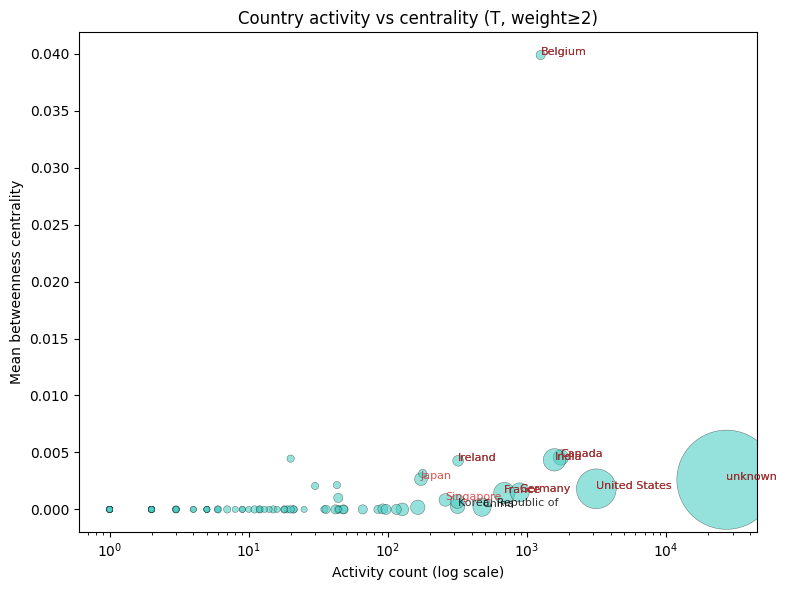

In [77]:
# Scatter plot activity vs mean betweenness where size encodes node count
plt.figure(figsize=(8, 6))
sizes = 20 + 8 * combined["node_count"]
plt.scatter(combined["activity_count"], combined["betweenness_mean"], s=sizes, alpha=0.6, color="#4ECDC4", edgecolor="black", linewidth=0.3)
plt.xscale("log")
plt.xlabel("Activity count (log scale)")
plt.ylabel("Mean betweenness centrality")
plt.title("Country activity vs centrality (T, weight≥2)")

# Annotate top activity and top central countries
for country, row in top_activity.iterrows():
    plt.annotate(country, (row["activity_count"], row["betweenness_mean"]), fontsize=8, alpha=0.8)
for country, row in top_central.iterrows():
    plt.annotate(country, (row["activity_count"], row["betweenness_mean"]), fontsize=8, alpha=0.8, color="tab:red")

plt.tight_layout()
plt.show()

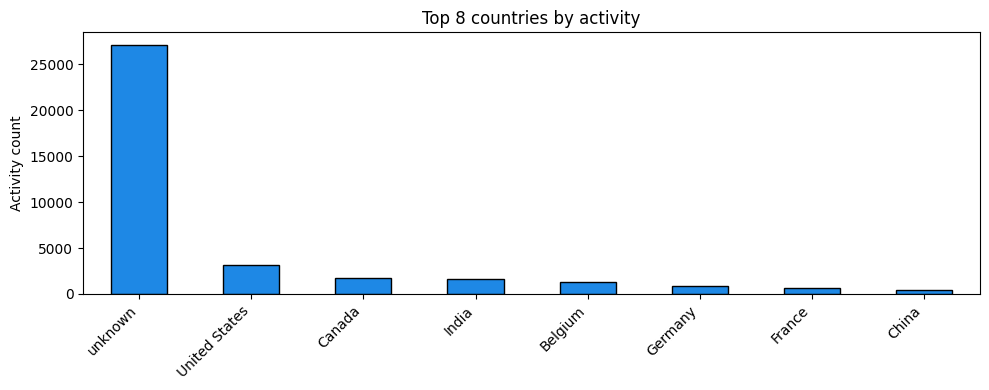

In [76]:
plt.figure(figsize=(10, 4))
top8_activity = combined_sorted.head(8)
top8_activity["activity_count"].plot(kind="bar", color="#1E88E5", edgecolor="black")
plt.ylabel("Activity count")
plt.title("Top 8 countries by activity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()